# Twitch(트위치) 채팅 데이터 EDA & 전처리

## raw data

chatty 라는 프로그램을 이용해 하루 동안 모은 채팅 로그입니다.

방송 주제에 관계 없이 여러 스트리머들의 실시간 채팅을 가져왔습니다.

In [1]:
import re
import os

path = os.getcwd()
log_list = [file for file in os.listdir(path+"/twitch") if file[0] == '#']

log = []

for file in log_list:
    with open(os.path.join(path, "twitch", file), "r") as f:
        log += f.read().splitlines()

log[:10]

['# Log started: 2021-12-10 23:26:48 +0900',
 '[2021-12-10 23:26:48] #sorammmm 채널 입장 중입니다',
 '[2021-12-10 23:26:48] #sorammmm 채널에 입장했습니다',
 '[2021-12-10 23:26:49] ~다이아 ㄱ (League of Legends)~',
 '[2021-12-10 23:26:51] <%전준우 (lotteno8)> ㅋㅋㅋ;',
 '[2021-12-10 23:26:52] <%티르나 (tonsia)> a를 더 자주누르면되는거 아닌가? ㅋㅋㅋㅋ',
 '[2021-12-10 23:27:00] <cannonthief9999> 그 누구지 땅우양은 그냥 사거릴 외우라던대',
 '[2021-12-10 23:27:03] <참스참스 (charmx_)> 선생님 두오는 몬가요?',
 '[2021-12-10 23:27:04] <%전준우 (lotteno8)> 뭐 자신만의 카이팅이 있으니까..',
 '[2021-12-10 23:27:04] <100연차폭사 (9thse)> 기억력이 금붕어라십니다']

## processing raw data

chatty로 가져온 로그는 chatty 자체에서 찍은 로그(ex. 첫번째 줄)와

방송 상황과 유저 채팅을 타임스탬프와 같이 기록한 로그가 있습니다.

유저 채팅을 가져오기 위해 타임스탬프가 찍힌 줄을 전처리 해 가져옵니다.

In [2]:
text = [line[22:].strip() for line in log 
        if re.match("\[\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}\]", line)]
print(len(text))
text[:10]

1458182


['#sorammmm 채널 입장 중입니다',
 '#sorammmm 채널에 입장했습니다',
 '~다이아 ㄱ (League of Legends)~',
 '<%전준우 (lotteno8)> ㅋㅋㅋ;',
 '<%티르나 (tonsia)> a를 더 자주누르면되는거 아닌가? ㅋㅋㅋㅋ',
 '<cannonthief9999> 그 누구지 땅우양은 그냥 사거릴 외우라던대',
 '<참스참스 (charmx_)> 선생님 두오는 몬가요?',
 '<%전준우 (lotteno8)> 뭐 자신만의 카이팅이 있으니까..',
 '<100연차폭사 (9thse)> 기억력이 금붕어라십니다',
 '<감사합니다영어님 (sunkist09300)> 김쿠하님은 근데 징크스 원챔러에여? ㅋㅋㅋ']

## Filtering only user chat

방송 상황과 유저 채팅 중 유저 채팅만 거르기 위해 전처리합니다.

"<>"괄호 안에 유저 이름과 그 옆에 채팅이 나오기 때문에 그 부분을 가져옵니다.

In [3]:
chat = [line for line in text if re.match("<.+>", line)]
print(len(text))
chat[:10]

1458182


['<%전준우 (lotteno8)> ㅋㅋㅋ;',
 '<%티르나 (tonsia)> a를 더 자주누르면되는거 아닌가? ㅋㅋㅋㅋ',
 '<cannonthief9999> 그 누구지 땅우양은 그냥 사거릴 외우라던대',
 '<참스참스 (charmx_)> 선생님 두오는 몬가요?',
 '<%전준우 (lotteno8)> 뭐 자신만의 카이팅이 있으니까..',
 '<100연차폭사 (9thse)> 기억력이 금붕어라십니다',
 '<감사합니다영어님 (sunkist09300)> 김쿠하님은 근데 징크스 원챔러에여? ㅋㅋㅋ',
 '<%티르나 (tonsia)> 이득봤으면 됐어',
 '<roger55590> 김쿠하는 드브장인임. ㅋㅋ',
 '<whehdrb702> 쿠하 야스오잘함']

# EDA twitch chat log

1. ID의 양상을 살펴봅니다.

2. Chat의 양상을 살펴봅니다.

3. 위를 바탕으로 preprocessing rule을 정합니다.

In [4]:
from tqdm import tqdm

id_list = []
chat_list = []
nickname_letters = set()
id_letters = set()

for t in tqdm(chat):
    
    # ID 있는지 확인
    user_id = re.match("<.+?>", t)
    if user_id: user_id = user_id.group()
    else: continue

    # 닉네임이 있는지 확인
    id_in_parentheses = re.search(r"\(.+?\)", user_id[1:-1])
    
    # ID와 닉네임에 쓰인 글자들 수집
    if id_in_parentheses:
        id_letters.update(list(id_in_parentheses.group()[1:-1]))
        nickname_letters.update(list(re.match(r"(.+? )", user_id[1:-1]).group().strip()))
    else:
        id_letters.update(list(user_id[1:-1]))
    
    # id 옆의 채팅 가져오기
    user_chat = t[len(user_id)+1:]
    id_list.append(user_id)
    chat_list.append(user_chat)

nickname_letters = ''.join(sorted(list(nickname_letters)))
nickname_letters = re.sub(r"[ㄱ-ㅎㅏ-ㅣ가-힣ぁ-ゔァ-ヴー々〆〤一-龥\w\s]", "", nickname_letters)
id_letters = ''.join(sorted(list(id_letters)))
id_letters = re.sub(r"[ㄱ-ㅎㅏ-ㅣ가-힣ぁ-ゔァ-ヴー々〆〤一-龥\w\s]", "", id_letters)

100%|██████████| 1454202/1454202 [00:09<00:00, 161462.94it/s]


In [5]:
from pprint import pprint

print(f"전체 데이터 개수: {len(id_list)}")
print()

print("="*25, "[ID 예시]", "="*30)
pprint(id_list[:5])
print()
print("닉네임에 들어가는 특수문자들:", nickname_letters)
print()
print("각 특수문자가 포함되는 닉네임 별 채팅 예시")
for symbol in nickname_letters:
    tmp_list = []
    tmp_id_list = []
    print(f"symbol: {symbol}")
    for i, user_id in enumerate(id_list):
        tmp = ''
        if len(tmp_list) == 10:
            break
        elif re.search(r"\(.+?\)", user_id[1:-1]):
            tmp = re.match(r"(.+? )", user_id[1:-1]).group().strip()
            if symbol in tmp and tmp not in tmp_id_list:
                tmp_id_list.append(tmp)
                tmp_list.append(' '.join([user_id, chat_list[i]]))
        else:
            continue
    pprint(tmp_list)
    print()
print("-"*70)
print()
print("ID에 들어가는 특수문자들:", id_letters)
print()
print("각 특수문자가 포함되는 ID 별 채팅 예시")
for symbol in id_letters:
    tmp_list = []
    tmp_id_list = []
    print(f"symbol: {symbol}")
    for i, user_id in enumerate(id_list):
        tmp = ''
        if len(tmp_list) == 10:
            break
        elif re.search(r"\(.+?\)", user_id[1:-1]):
            tmp = re.search(r"\(.+?\)", user_id[1:-1]).group().strip()
            if symbol in tmp and tmp not in tmp_id_list:
                tmp_id_list.append(tmp)
                tmp_list.append(' '.join([user_id, chat_list[i]]))
        else:
            tmp = user_id[1:-1]
            if symbol in tmp and tmp not in tmp_id_list:
                tmp_id_list.append(tmp)
                tmp_list.append(' '.join([user_id, chat_list[i]]))
    pprint(tmp_list)
    print()

전체 데이터 개수: 1454202

========================= [ID 예시] ==============================
['<%전준우 (lotteno8)>',
 '<%티르나 (tonsia)>',
 '<cannonthief9999>',
 '<참스참스 (charmx_)>',
 '<%전준우 (lotteno8)>']

닉네임에 들어가는 특수문자들: !$%+@^~㉹

각 특수문자가 포함되는 닉네임 별 채팅 예시
symbol: !
['<!삐부 (s1032204)> 두디 이러다가 뇌 말랑말랑해지겟어',
 '<!미로씌 (mirosee)> 형..나가면 안되는거야..',
 '<!%러브새키 (lovesaeki_)> 여행가서 자기전에 전화해',
 '<!한예찬 (yechan9712)> 뚜띠 놀러감 ?',
 '<!%연초봄 (yeonchobom)> 나 11학번인데',
 '<!일루전_ (ow_illusion)> 갱하',
 '<!%해나 (haena_0714)> 들어오자마자 만약에지옥이다',
 '<!%링거솔루션99 (ringersolution99)> 별거아니네',
 '<!이카링링 (vkql99)> 오랫만에 왔는데.. 빡겜이 맞는건가요?',
 '<!정지차니 (wkdusfl0924)> 오늘 복장 합격']

symbol: $
['<$잘하고있다 (erer5690)> 오늘 이거 켠왕이에요?ㅋㅋㅋㅋㅋ',
 '<$발릭 (djhany1)> 슈퍼엘리트는 첨보네',
 '<%$원탁_ (dldnjsxkr12_)> ㅎㅎ~',
 '<$쏜_방심윤홍 (reggjs85722)> 감귤피자',
 '<$큼퍼스 (ilsangop)> 물쥐 고독사하기 일보직전 ㅋㅋㅋ',
 '<$거출배 (skysmomo)> 아니 이거 대각이라',
 '<$블루블루대광어 (pos100100)> !업타임',
 '<%$ミ자이드런 (dydrkf25)> 저도요',
 '<%$여용_ (dudyd_)> ㅋㅋㅋㅋㅋㅋㅋㅋ',
 '<%$ミ_레드향 (red_aroma)> ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']

symbol: %
['<%전준우 


========================= [채팅 예시] ==============================

['ㅋㅋㅋ;',
 'a를 더 자주누르면되는거 아닌가? ㅋㅋㅋㅋ',
 '그 누구지 땅우양은 그냥 사거릴 외우라던대',
 '선생님 두오는 몬가요?',
 '뭐 자신만의 카이팅이 있으니까..',
 '기억력이 금붕어라십니다',
 '김쿠하님은 근데 징크스 원챔러에여? ㅋㅋㅋ',
 '이득봤으면 됐어',
 '김쿠하는 드브장인임. ㅋㅋ',
 '쿠하 야스오잘함']

채팅 평균 길이: 9.383490739250806
채팅 최대 길이: 500
채팅 최소 길이: 1


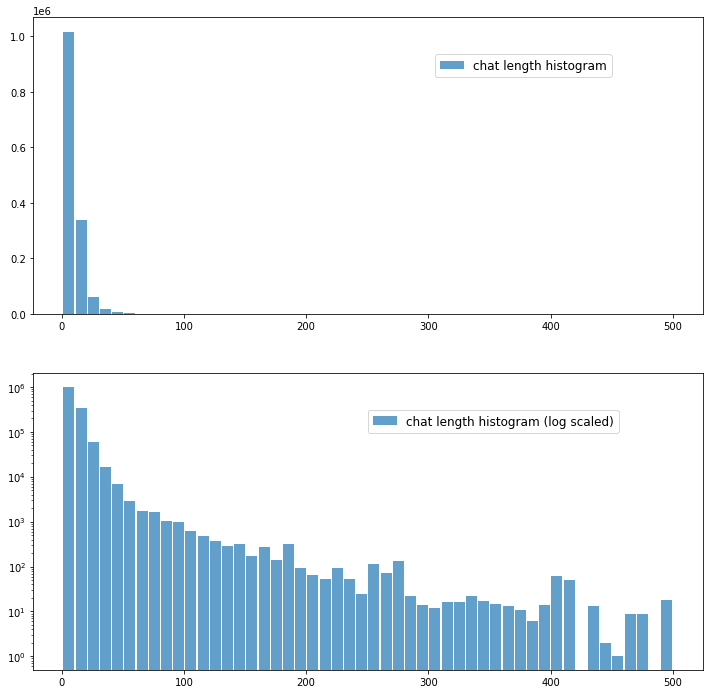


채팅의 여러 양상들 분석


1. 자음이나 모음만 있는 채팅 예시

['ㅋㅎㅎㅋㅎㅋㅎㅋ',
 'ㄴㅇㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴㄴ',
 'ㅌㅌㅌㅌㅌㅌㅌㅌㅌㅌ',
 'ㅇㄴㅋㅎㅋㅎㅋㅎㅋㅋㅋㅎㅋㅎㅎㅋㅋㅎㅎㅋㅎㅋㅎㅋㅎㅋㅎㅋㅎㅋㅎㅋ',
 'ㄱㅇㅁㅅㅆ',
 'ㅌㅌㅌㅌㅌㅌㅋㅋㅋㅋㅋ',
 'ㅌㅌㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅇㅈ',
 'ㅇㅈㄴㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅂㄹㅇㅈㅆ']

['ㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖㅖ',
 'ㅜㅑㅑ',
 'ㅠㅜㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ',
 'ㅜㅏㅏㅏㅏㅏㅏㅏㅏ',
 'ㅝ',
 'ㅡ',
 'ㅠㅠㅠㅜㅜㅠㅠㅠㅠㅠㅠㅠ',
 'ㅝㅗㅝ',
 'ㅏㅏㅏㅏㅏㅑ',
 'ㅣㅣㅣㅣㅣㅣㅗㅗㅗㅗㅗㅗ']

['ㅇㅘㅏㅏㅏㅏㅏ',
 'ㅠㅠㅠㅍㅍ',
 'ㄴㅇㅅㅜㅜㅜㅜㅜㅜ',
 'ㄷㅏㄹㄷㅏ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅣㄱㅋㅋㅋ',
 'ㅇㅈㅠ',
 'ㅋㅋㅋㅋㅋㅣㄱㅋㅋ',
 'ㅠㅠㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅔㅋ',
 'ㅓㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']


2. 한 글자가 반복되는 채팅 예시

['ㅋㄱㅋㅋㅋㅋㅋㅋㅋㄱㄱㄱㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㄱㅋㄱㅋㄱㅋㄱㅋㅋ',
 'ㅋㅋㅋㅋㄱㄱㅋㄱㄱㅋㅋㅋㅋ',
 'ㅋㅋㅋㄱㄱㅋㅋㅋㄱㅋ',
 'ㅋㄱㄱㄱㄱㄱㄱㄱ',
 'ㅋㄲㅋㅋㅋㅋㅋㅋ']

['zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
 'zzzzzzzzzzzzzzzzzzzzzz',
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
 'zzzzzzzzzzz',
 'ZZZZZZZZZZZZZZZZZZZZZZ',
 'zzzzzzzzzz']

['ㄸㄸㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷ',
 'ㄸㄸㄸㄸㄸㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄸ']

['ee', 'E', 'EE', 'eeeeeeeeeeee', 'eeee', 'eeeeee']

['ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ',
 'ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ

In [10]:
import numpy as np
import matplotlib.pyplot as plt

print()
print("="*25, "[채팅 예시]", "="*30)
print()
pprint(chat_list[:10])
print()
len_list = np.array([len(x) for x in chat_list])
print("채팅 평균 길이:", sum(len_list)/len(len_list))
print("채팅 최대 길이:", max(len_list))
print("채팅 최소 길이:", min(len_list))

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
axs[0].hist(len_list, bins=50, alpha=0.7, rwidth=0.9, label="chat length histogram")
axs[0].legend(fontsize=12, loc=(0.6, 0.8))
axs[1].hist(len_list, bins=50, alpha=0.7, rwidth=0.9, label="chat length histogram (log scaled)")
axs[1].legend(fontsize=12, loc=(0.5, 0.8))
axs[1].set_yscale("log")
plt.show()

consonants, vowels, con_vows = [], [], []
only_k, only_z, only_d, only_e, only_g, only_gg, only_dot, only_colon, only_one = [], [], [], [], [], [], [], [], []
only_num, only_symbol, only_num_and_alpha, only_alpha = [], [], [], []
only_ch, only_jp, only_es, only_ar, only_other_short, only_other_long = [], [], [], [], [], []
long_sent, command = [], []
for t in chat_list:
    if re.fullmatch(r"[ㄱㄲㅋ]+", t):
        only_k.append(t)
    elif re.fullmatch(r"[Zz]+", t):
        only_z.append(t)
    elif re.fullmatch(r"[ㄷㄸ]+", t):
        only_d.append(t)
    elif re.fullmatch(r"[Ee]+", t):
        only_e.append(t)
    elif re.fullmatch(r"ㅎ+", t):
        only_g.append(t)
    elif re.fullmatch(r"[Gg]+", t):
        only_gg.append(t)
    elif re.fullmatch(r"[ㄱ-ㅎ]+", t):
        consonants.append(t)
    elif re.fullmatch(r"[ㅏ-ㅣ]+", t):
        vowels.append(t)
    elif re.fullmatch(r"[ㄱ-ㅎㅏ-ㅣ]+", t):
        con_vows.append(t)
    elif re.fullmatch(r"\.+", t):
        only_dot.append(t)
    elif re.fullmatch(r"([:;])+", t):
        only_colon.append(t)
    elif re.fullmatch(r"(.)\1+", t):
        only_one.append(t)
    elif re.fullmatch(r"[0-9\s]+", t):
        only_num.append(t)
    elif re.fullmatch(r"[\\/\^\(\)\[\]{}<>,\.:;~\-_=+`\'\"\?!@#$%&*\s]+", t):
        only_symbol.append(t)
    elif re.fullmatch(r"[a-zA-Z\s]+", t):
        only_alpha.append(t)  
    elif re.fullmatch(r"[a-zA-Z0-9\s]+", t):
        only_num_and_alpha.append(t)
    elif t[0] == '!':
        command.append(t)
    elif re.fullmatch(r"[ぁ-ゔゞァ-・ヽヾ゛゜ー、。’！：／\d\s]+", t):
        only_jp.append(t)
    elif re.fullmatch(r"[\u3000-\u303F\u3400-\u4DBF\u4E00-\u9FFF、。’！：／\d\s]+", t):
        only_ch.append(t)
    elif re.fullmatch(r"[À-ÿ\w\s]+", t):
        only_es.append(t)
    elif re.search(r"[ء-ي]+", t):
        only_ar.append(t)
    elif len(t) < 3 and re.fullmatch(r"[^\wㄱ-ㅎㅏ-ㅣ가-힣À-ÿء-ي]+", t):
        only_other_short.append(t)
    elif len(t) > 10 and re.fullmatch(r"[^\wㄱ-ㅎㅏ-ㅣ가-힣À-ÿء-ي]+", t):
        only_other_long.append(t)
    if len(t) > 24:
        long_sent.append(t)

print()
print("채팅의 여러 양상들 분석")
print("\n" + "="*70 + "\n")
print("1. 자음이나 모음만 있는 채팅 예시\n")
pprint(list(set(consonants))[:10])
print()
pprint(list(set(vowels))[:10])
print()
pprint(list(set(con_vows))[:10])
print("\n" + "="*70 + "\n")
print("2. 한 글자가 반복되는 채팅 예시\n")
pprint(list(set(only_k))[:6])
print()
pprint(list(set(only_z))[:6])
print()
pprint(list(set(only_d))[:6])
print()
pprint(list(set(only_e))[:6])
print()
pprint(list(set(only_g))[:6])
print()
pprint(list(set(only_gg))[:6])
print()
pprint(list(set(only_dot))[:6])
print()
pprint(list(set(only_colon))[:6])
print()
pprint(list(set(only_one))[:20])
print("\n" + "="*70 + "\n")
print("3. 숫자만, 기호들만, 영문/숫자만, 영어만, 다른 언어들만\n")
pprint(list(set(only_num))[:6])
print()
pprint(list(set(only_symbol))[:10])
print()
pprint(list(set(only_num_and_alpha))[:10])
print()
pprint(list(set(only_alpha))[:10])
print()
pprint(list(set(only_ch))[:6])
print()
pprint(list(set(only_jp))[:6])
print()
pprint(list(set(only_es))[:6])
print()
pprint(list(set(only_ar))[:6])
print()
pprint(list(set(only_other_short))[:30])
print()
pprint(list(set(only_other_long))[:10])
print("\n" + "="*70 + "\n")
print("4. 길이가 긴 문장들\n")
pprint(list(set(long_sent))[:30])
print("\n" + "="*70 + "\n")
print("5. 명령어들\n")
pprint(list(set(command))[:20])

## Preprocessing 전략

1. ID에 '^', '*', '&'가 있는 경우 거르기
> ID에 '^'가 있으면 Ssakdook이나 Nightbot 등 채팅 관리 봇, '*'는 global moderator, '&'는 스태프 or admin

2. 한글, 한자, 영어, 숫자, 특수문자들 제외 모두 삭제
> 다른 언어나 특수한 기호들은 Tokenizer를 방해할 수도 있을 듯

3. 다만 한자만, 숫자만, 특수문자만 있는 경우도 삭제
> 채팅을 거르는 의미가 없다고 판단

4. 반복되는 글자나 단어, 문장은 최대한 substring을 찾아서 반환
> 의미없이 반복적인 문장은 학습과 추론에 방해된다 판단

## Deleting Emote (twitch emoji)

트위치에는 트위치 채팅에만 쓸 수 있는 이모지(Emote)가 있습니다.

스트리머들 마다 각자 자기만의 emote를 제작할 수도 있어서 전부를 거르지는 못하지만,

기본 emote는 텍스트로 가져와서 걸러줍니다.

In [7]:
# 트위치 기본 emote와 텍스트에서 많이 나오는 emote(?)
from collections import Counter

with open(os.path.join(path, "emote.txt"), "r") as f:
    emote = f.read().splitlines()
print(len(emote))

emote_ = [re.escape(emo) for emo in list(set(emote))]

emote_pattern1 = re.compile('|'.join(emote_[:20]))
emote_pattern2 = re.compile('|'.join(emote_[20:40]))
emote_pattern3 = re.compile('|'.join(emote_[40:60]))
emote_pattern4 = re.compile('|'.join(emote_[60:80]))
emote_pattern5 = re.compile('|'.join(emote_[80:100]))
emote_pattern6 = re.compile('|'.join(emote_[100:120]))
emote_pattern7 = re.compile('|'.join(emote_[120:140]))
emote_pattern8 = re.compile('|'.join(emote_[140:160]))
emote_pattern9 = re.compile('|'.join(emote_[160:180]))
emote_pattern10 = re.compile('|'.join(emote_[180:200]))
emote_pattern11 = re.compile('|'.join(emote_[200:220]))
emote_pattern12 = re.compile('|'.join(emote_[220:240]))
emote_pattern13 = re.compile('|'.join(emote_[240:260]))
emote_pattern14 = re.compile('|'.join(emote_[260:]))

def delete_emote(s):
    s = emote_pattern1.sub(r"", s)
    s = emote_pattern2.sub(r"", s)
    s = emote_pattern3.sub(r"", s)
    s = emote_pattern4.sub(r"", s)
    s = emote_pattern5.sub(r"", s)
    s = emote_pattern6.sub(r"", s)
    s = emote_pattern7.sub(r"", s)
    s = emote_pattern8.sub(r"", s)
    s = emote_pattern9.sub(r"", s)
    s = emote_pattern10.sub(r"", s)
    s = emote_pattern11.sub(r"", s)
    s = emote_pattern12.sub(r"", s)
    s = emote_pattern13.sub(r"", s)
    s = emote_pattern14.sub(r"", s)
    return s

275


## Filtering repeated substring

트위치 채팅의 큰 특징 중 하나는 같은 문장을 여러 번 복사/붙여넣기 하는 경우가 빈번하다는 점입니다.

문장을 여러 번 복사/붙여넣기를 하면 딥러닝 모델이 잘 학습되지도 않고, 추론도 어렵기 때문에 반복되고 있는 문장(substring)을 최대한 찾아내어 걸러줍니다.

여러 경우의 수를 고려해 여러 번 시도하기 때문에 preprocessing 속도가 조금 느려지지만, 작성한 함수의 속도가 매우 빠른 편이기 때문에 실제로 걸리는 속도는 여전히 매우 빠릅니다.

다만, 반복 중간에 다른 문자가 있거나 혹은 반복 중 substring에 변화가 있는 경우는 찾아 낸다고 하더라도 연산 속도가 매우 느려지고, 또한 완벽하게 substring을 검출하는 방법을 못 찾았기 때문에 set()를 이용하여 간단하게만 걸러주었습니다.

In [8]:
# 복붙 도배 문장 걸러내는 함수
def principal_period(s):
    i = (s+s).find(s, 1, -1)
    return None if i == -1 else s[:i]

def check_repeat(user_chat):
    if principal_period(user_chat): # 복붙으로 도배한 문장 걸러서 통과 (띄어쓰기 없이 복붙)
        s = principal_period(user_chat)
        if len(s) <= 3: # 반복되는 문장이 3글자 이하면 1번 반복 시킴
            return s+s
        else: # 이외에는 반복 X
            return s
    
    elif principal_period(user_chat + " "): # 복붙으로 도배한 문장 걸러서 통과 (띄어쓰기 있는 복붙)
        s = principal_period(user_chat + " ")
        if len(s) <= 3:
            return s+s
        else:
            return s
        
    user_chat = user_chat[:-1] # 복붙 후 마지막에 v, ㅍ, ' 등이 붙는 경우
    
    # 위와 동일
    if principal_period(user_chat):
        s = principal_period(user_chat)
        if len(s) <= 3:
            return s+s
        else:
            return s
    
    elif principal_period(user_chat + " "):
        s = principal_period(user_chat + " ")
        if len(s) <= 3:
            return s+s
        else:
            return s
    
    return None # 해당 사항 없으면 None 리턴

In [33]:
chat_log = []

for t in tqdm(chat):
    
    user_id = re.match("<.+?>", t)
    if user_id: user_id = user_id.group()
    else: continue
    user_chat = t[len(user_id)+1:]
    
    if re.search("Twipkr", user_id): # Twipkr 제외
        continue
        
    id_in_parentheses = re.search(r"\(.+?\)", user_id[1:-1])
    if id_in_parentheses:
        nickname = re.match(r"(.+? )", user_id[1:-1]).group().strip()
        if re.search(r"\^\*&", nickname):
            continue
        user_id = id_in_parentheses.group()[1:-1]   
    else:
        user_id = user_id[1:-1]
        if re.search(r"\^\*&", user_id):
            continue
            
    user_chat = delete_emote(user_chat)

    user_chat = re.sub(r"\s+", r" ", user_chat)
    user_chat = re.sub(r"[“”‘’]", r"\'", user_chat)
    user_chat = re.sub(r"[〈<＜「≪《『]", "<", user_chat)
    user_chat = re.sub(r"[〉>＞」≫》』]", ">", user_chat)
    user_chat = re.sub(r'[‥…]+', r'...', user_chat)
    user_chat = re.sub(r'[\?¿？]+', r'\?', user_chat)
    user_chat = re.sub(r'[!¡！]+', r'!', user_chat)
    user_chat = re.sub(r"([^\-—_=+,\./<>?\[\]{};:\'\"!@#$%\^&*\(\)₩`´~\|\\ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9ぁ-ゔゞァ-・ヽヾ゛゜ー一-龯\u3000-\u303F\u3400-\u4DBF\u4E00-\u9FFF\s]+)", r'', user_chat)
    
    if len(user_chat) == 0: continue
    
    elif user_chat[0] == '!': continue
    
    elif re.fullmatch(r"[ㄱㄲㅋㄷㄸㅎㅠㅜZEGzeg\-=\?!\d\s]+", user_chat): # z(ㅋ), e(ㄷ), ㅎ, G/g(gg) + 숫자만 있는 문장 제거
        zeg += 1
        continue
    
    elif re.fullmatch(r"[ぁ-ゔゞァ-・ヽヾ゛゜ー一-龯w\d\s]+", user_chat): # w, 숫자, 일본어만 있는 문장 제거
        jp += 1
        continue
        
    elif re.fullmatch(r"[\u3000-\u303F\u3400-\u4DBF\u4E00-\u9FFF\d\s]+", user_chat): # 영어, 숫자, 중국어만 있는 문장 제거
        ch += 1
        continue
            
    elif re.fullmatch(r"[₩/\\\(\)\[\]<>\-_=+@#$%\^&*,\.;:\'\"\?!\s]+", user_chat): # 문장부호, 특수기호만 있는 문장 제거
        continue
    
    rep = check_repeat(user_chat)
    if rep: user_chat = rep
    
    while re.search(r"(.)\1{4,}", fr"{user_chat}"):  # 4번 이상 반복되는 글자 3번만 반복되도록 수정
        repeated = re.search(r"(.)\1{4,}", fr"{user_chat}").group()
        if repeated[0] == '^':
            user_chat = re.sub(r'\^+', r'^^^', user_chat)
        try:
            user_chat = re.sub(repeated, repeated[0]*3, user_chat)
        except: break
            
    user_chat = re.sub(r"\\", "", user_chat) # 백슬래쉬 제거
    
    chat_log.append((user_id, user_chat))

len(chat_log)

100%|██████████| 1454202/1454202 [00:47<00:00, 30915.36it/s]


1120729

In [34]:
import pandas as pd

df = pd.DataFrame(chat_log, columns=["id", "chat"])
df.head(10)
len(df)

1120729

In [35]:
chat_log_without_repeat = []
chat_set = set()

for i, c in tqdm(chat_log):
    if c in chat_set:
        continue
    else:
        chat_set.add(c)
        chat_log_without_repeat.append((i, c))
    
df_without_repeat = pd.DataFrame(chat_log_without_repeat, columns=["id", "text"])
df_without_repeat.head(10)
len(df_without_repeat)

100%|██████████| 1120729/1120729 [00:00<00:00, 1240597.40it/s]


720435

In [36]:
df_without_repeat.to_csv("chatData.tsv", sep='\t', index=False)